/var/folders/p3/rf4qqwbj5td08r07369s000r0000gn/T/ipykernel_10649/1014828539.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_copy[col] = data_copy[col].fillna(data_copy[col].mode()[0])


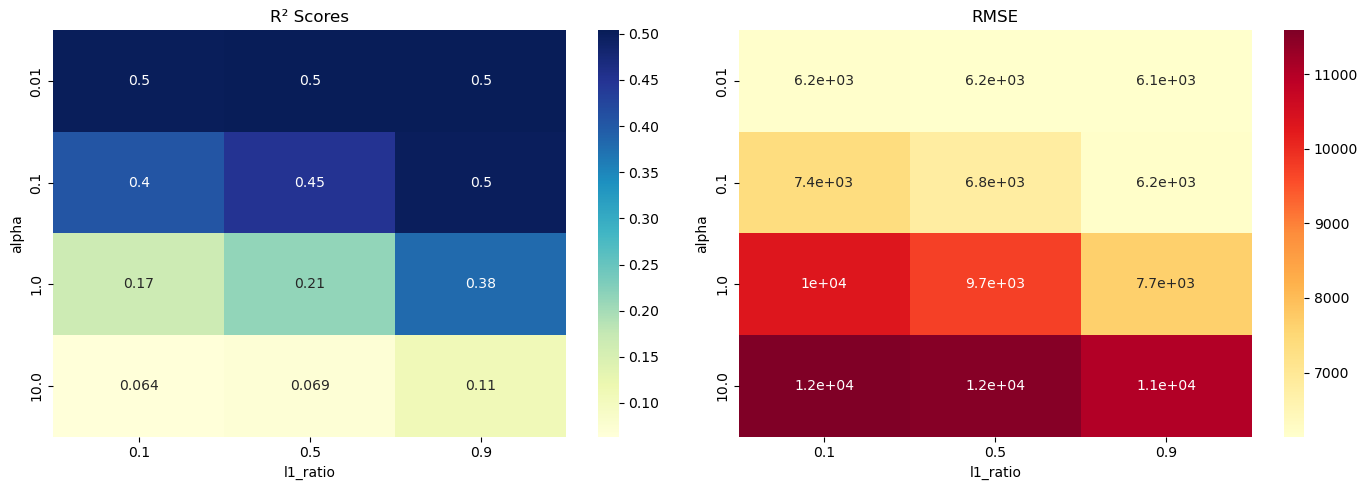

In [7]:
# Import necessary modules
# import data_preprocessor as dp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

#Load the dataset
import pandas as pd
data = pd.read_csv('../Data/heart_disease_uci.csv')

#Data Preprocessing
# #check the data types
# print(df.dtypes)
# # Check for missing values
# print(data.isnull().sum())

#impute missing values if necessary (for cholesterol)
data_copy = data.copy()

#Drop columns that have high missing values (>35% missing values)
data_copy = data_copy.drop(columns=['slope','ca','thal'], errors='ignore')

# Identify numerical and categorical columns
numerical_col_name = data_copy.select_dtypes(include=['number']).columns
categorical_col_name = data_copy.select_dtypes(include=['object']).columns

#Fill missing values in numerical with mean and categorical with mode
for col in numerical_col_name:
    data_copy[col] = data_copy[col].fillna(data_copy[col].mean())
for col in categorical_col_name:
    data_copy[col] = data_copy[col].fillna(data_copy[col].mode()[0])


#Drop duplicates
data_copy = data_copy.drop_duplicates()


# Convert categorical columns to numerical using OneHotEncoder (ChatGPT, 2025)
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(data_copy[categorical_col_name])
# Create a DataFrame with the encoded categorical columns
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_col_name))
# Concatenate the encoded categorical DataFrame with the original DataFrame (excluding original categorical columns)
data_copy = pd.concat([data_copy[numerical_col_name], encoded_df], axis=1)

# # Fill any remaining NaN values (if any) after encoding
data_copy = data_copy.fillna(data_copy.mean(numeric_only=True))  # for numeric
data_copy = data_copy.fillna(0)  # fallback for any non-numeric leftovers

data_copy.to_csv('../Data/data_copy.csv', index=False)
# print(data_copy.columns)
# print(data_copy.dtypes)



#__________________
#REGRESSION MODEL (ElasticNet with hyperparameter heatmap)

#Set up the x and y 
x_reg = data_copy.drop(columns=['chol']) #everything else except 'chol' are features 
y_reg= data_copy['chol'] #chol is target variable

#Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_reg, y_reg, test_size = 0.2, random_state=42)

# Define ranges for alpha and l1_ratio
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]

r2_scores = []
rmse_scores = []

for alpha in alphas:
    r2_row = []
    rmse_row = []
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        r2_row.append(r2_score(y_test, y_pred))
        rmse_row.append(mean_squared_error(y_test, y_pred))  # RMSE
    r2_scores.append(r2_row)
    rmse_scores.append(rmse_row)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(r2_scores, annot=True, xticklabels=l1_ratios, yticklabels=alphas, ax=axes[0], cmap='YlGnBu')
axes[0].set_title('R² Scores')
axes[0].set_xlabel('l1_ratio')
axes[0].set_ylabel('alpha')

sns.heatmap(rmse_scores, annot=True, xticklabels=l1_ratios, yticklabels=alphas, ax=axes[1], cmap='YlOrRd')
axes[1].set_title('RMSE')
axes[1].set_xlabel('l1_ratio')
axes[1].set_ylabel('alpha')

plt.tight_layout()
plt.show()


#____________________
#CLASSIFICATION MODEL
